In [1]:
# 隨機從dataset中挑選N筆資料
from os import walk
from os.path import join
from os import stat
import random
import hashlib
import time

mypath = "D:\Download\enron"

# store all the fullpath of files in the root directory
file_names = []

# only store files size bigger than 5K
for root, dirs, files in walk(mypath):
    for f in files:
        fullpath = join(root, f)
        if(stat(fullpath).st_size >= 5000):
            file_names.append(fullpath)

In [37]:
# store 1000 fullpath to upload
upload_files = []
# store 200 fullpath to check dulplicate
check_files = []

# three lists simulate cloud server
dirty_chunk = []
cloud_hash = []

# check file data
check_hash = []

In [38]:
# os.stat(file).st_size return size of the file in bytes
# for i in range(1000):
#     random_int = random.randint(0, len(file_names) - 1)
#     upload_files.append(file_names[random_int])
upload_files = random.sample(file_names, k = 1000)  #upload 1K no-repeated files
    
# for i in range(200):
#     random_int = random.randint(0, len(file_names) - 1)
#     check_files.append(file_names[random_int])
check_files = random.choices(file_names, k = 200)
    
same_file = 0
for cf in check_files:
    if(cf in upload_files):
        same_file += 1
print('same file amount between cloud file and check file:', same_file)

same file amount between cloud file and check file: 8


In [39]:
def upload_file(chunk_size):
    global cloud_hash
    for file in upload_files:
        with open(file, 'rb') as f:
            text = f.read()
        f.close()

#         if(len(text) % chunk_size != 0):
#             for i in range(chunk_size - (len(text) % chunk_size)):
#                 text += bytes.fromhex('30')
        
        for i in range(0, len(text), chunk_size):
            cloud_hash.append(hashlib.sha256(text[i: i + chunk_size]).hexdigest())
    
    cloud_hash = list(set(cloud_hash))
        
def cut_check_file(chunk_size):
    for file in check_files:
        with open(file, 'rb') as f:
            text = f.read()
        f.close()

    #         if(len(text) % chunk_size != 0):
    #             for j in range(chunk_size - (len(text) % chunk_size)):
    #                 text += bytes.fromhex('30')

        for i in range(0, len(text), chunk_size):
            check_hash.append(hashlib.sha256(text[i: i + chunk_size]).hexdigest())

    if(len(check_hash) % 2 != 0):
        check_hash.append(random.choice(check_hash))    

In [40]:
def set_dirty_chunk(dirty_percent):
    dirty_chunk = random.sample(cloud_hash, k = int(len(cloud_hash) * dirty_percent))

def zeus_check(chunk1, chunk2, hash_list):
    num = 0
    existence = 0
    for i in range(len(hash_list)):
        if(chunk1 == hash_list[i][0]):
            existence += 1
            if(hash_list[i][1] > 0):
                hash_list[i][1] -=1
            else:
                num += 1
            break
    if(existence < 1):
        hash_list.append([chunk1, 0])
    for i in range(len(hash_list)):
        if(chunk2 == hash_list[i][0]):
            existence += 1
            if(hash_list[i][1] > 0):
                hash_list[i][1] -=1
            else:
                num += 1
            break
    if(existence < 2):
        hash_list.append([chunk2, 0])
        
    return num

def zeus(chunk1, chunk2, hash_list):
    num = 0
    if(chunk1 in hash_list):
        num += 1
    else:
        hash_list.append(chunk1)
    if(chunk2 in hash_list):
        num += 1
    else:
        hash_list.append(chunk2)
    
    return num

def cal_commu_cost(chunk_size, is_zeus, has_dirty, thresh_max):
    upload_time = 0
    cost = 0
    hash_copy = cloud_hash.copy()
    dirty_copy = dirty_chunk.copy()
    
#     start_time = time.time()
    
    if(thresh_max > 0):
        for i in range(len(hash_copy)):
            hash_copy[i] = [hash_copy[i], random.randint(1, thresh_max)]
   
    if(is_zeus and thresh_max > 0):
        for i in range(0, len(check_hash), 2):
            cost += 64
            if(has_dirty):
                if((check_hash[i] in dirty_copy) or (check_hash[i + 1] in dirty_copy)):
                    if(check_hash[i] in dirty_copy):
                        dirty_copy.remove(check_hash[i])
                    if(check_hash[i + 1] in dirty_copy):
                        dirty_copy.remove(check_hash[i + 1])
                    val = zeus_check(check_hash[i], check_hash[i + 1], hash_copy)
                    cost += chunk_size * 2
                    upload_time += 2
                    continue
                    
            val = zeus_check(check_hash[i], check_hash[i + 1], hash_copy)
            if(val == 0):
                cost += chunk_size * 2
                upload_time += 2
            else:
#                 xor_result = hex(int(check_chunk[i].hex(), 16) ^ int(check_chunk[i + 1].hex(), 16))[2:]
#                 if(len(xor_result) < (chunk_size * 2)):
#                     for i in range((chunk_size * 2) - len(xor_result)):
#                         xor_result = '0' + xor_result
#                 cloud_copy.append(bytes.fromhex(xor_result))
                cost += chunk_size
                upload_time += 1
                    
    if(is_zeus and thresh_max == 0):
        for i in range(0, len(check_hash), 2):
            cost += 64
            if(has_dirty):
                if((check_hash[i] in dirty_copy) or (check_hash[i + 1] in dirty_copy)):
                    if(check_hash[i] in dirty_copy):
                        dirty_copy.remove(check_hash[i])
                    if(check_hash[i] not in hash_copy):
                        hash_copy.append(check_hash[i])
                    if(check_hash[i + 1] in dirty_copy):
                        dirty_copy.remove(check_hash[i + 1])
                    if(check_hash[i + 1] not in hash_copy):
                        hash_copy.append(check_hash[i + 1])
                    cost += chunk_size * 2
                    upload_time += 2
                    continue
                    
            val = zeus(check_hash[i], check_hash[i + 1], hash_copy)        
            if(val == 0):
                cost += chunk_size * 2
                upload_time += 2
            else:
#                 xor_result = hex(int(check_chunk[i].hex(), 16) ^ int(check_chunk[i + 1].hex(), 16))[2:]
#                 if(len(xor_result) < (chunk_size * 2)):
#                     for i in range((chunk_size * 2) - len(xor_result)):
#                         xor_result = '0' + xor_result
#                 cloud_copy.append(bytes.fromhex(xor_result))
                cost += chunk_size
                upload_time += 1
    if(not is_zeus):
        for i in range(len(check_hash)):
            cost += 32
            if(has_dirty):
                if(check_hash[i] in dirty_copy):
                    dirty_copy.remove(check_hash[i])
                    if(check_hash[i] not in hash_copy):
                        hash_copy.append(check_hash[i])
                    cost += chunk_size
                    upload_time += 1
                    continue
            if(check_hash[i] not in hash_copy):
                hash_copy.append(check_hash[i])
                cost += chunk_size
                upload_time += 1
                
#     end_time = time.time()
    if(has_dirty):
        if(is_zeus):
            if(thresh_max > 0):
                print('dirty ZEUS having threshold %d, with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (thresh_max, chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
            else:
                print('dirty ZEUS with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
        else:
            print('dirty original dedup with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    elif(is_zeus):
        if(thresh_max > 0):
            print('ZEUS having threshold %d, with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (thresh_max, chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
        else:
            print('ZEUS with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    else:
        print('origin dedup with chunk size: %d bytes,  dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    
    cost -= len(check_hash) * 32
    return cost

In [41]:
def rare(chunk1, chunk2, hash_list):
    num = 0
    if(chunk1 in hash_list):
        num += 1
    else:
        hash_list.append(chunk1)
    if(chunk2 in hash_list):
        num += 1
    else:
        hash_list.append(chunk2)
    
    if(num == 0):
        return 2
    else:
        val = random.randint(1, 2)
        return val

def rare_cost(chunk_size, do_dedup, do_rare, has_dirty):
    upload_time = 0
    cost = 0
    hash_copy = cloud_hash.copy()
    dirty_copy = dirty_chunk.copy()
    
#     start_time = time.time()
    
    if(do_dedup and do_rare):        
        for i in range(0, len(check_hash), 2):
            cost += 64
            if(has_dirty):
                if((check_hash[i] in dirty_copy) or (check_hash[i + 1] in dirty_copy)):
                    if(check_hash[i] in dirty_copy):
                        dirty_copy.remove(check_hash[i])
                    if(check_hash[i] not in hash_copy):
                        hash_copy.append(check_hash[i])
                    if(check_hash[i + 1] in dirty_copy):
                        dirty_copy.remove(check_hash[i + 1])
                    if(check_hash[i + 1] not in hash_copy):
                        hash_copy.append(check_hash[i + 1])
                    cost += chunk_size * 2
                    upload_time += 2
                    continue
            
            val = rare(check_hash[i], check_hash[i + 1], hash_copy)
            if(val == 2):
                cost += chunk_size * 2
                upload_time += 2
            else:
#                 xor_result = hex(int(check_chunk[i].hex(), 16) ^ int(check_chunk[i + 1].hex(), 16))[2:]
#                 if(len(xor_result) < (chunk_size * 2)):
#                     for i in range((chunk_size * 2) - len(xor_result)):
#                         xor_result = '0' + xor_result
#                 cloud_copy.append(bytes.fromhex(xor_result))
                cost += chunk_size
                upload_time += 1
    if(do_dedup and (not do_rare)):
        for i in range(len(check_hash)):
            cost += 32
            if(has_dirty):
                if(check_hash[i] in dirty_copy):
                    dirty_copy.remove(check_hash[i])
                    cost += chunk_size
                    upload_time += 1
                    if(check_hash[i] not in hash_copy):
                        hash_copy.append(check_hash[i])
                    continue
                
            if(check_hash[i] not in hash_copy):
                hash_copy.append(check_hash[i])
                cost += chunk_size
                upload_time += 1
    if(not do_dedup):
        cost = (32 + chunk_size) * len(check_hash)
        upload_time += len(check_hash)
    
#     end_time = time.time()
    if(has_dirty):
        if(do_rare):
            print('dirty RARE with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
        else:
            print('dirty original dedup with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    elif(do_rare):
        print('RARE with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    elif(do_dedup):
        print('origin dedup with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    else:
        print('no dedup with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    
    cost -= len(check_hash) * 32
    return cost

In [42]:
cloud_hash.clear()
dirty_chunk.clear()
check_hash.clear()

origin_costs = []
zeus_costs = []
zeus5_costs = []
zeus20_costs = []
zeus40_costs = []

no_dedup_costs = []
origin_dedup_costs = []
rare_costs = []

# no dirty chunk 128B
upload_file(128)
cut_check_file(128)
origin_costs.append(cal_commu_cost(128, False, False, 0))
zeus_costs.append(cal_commu_cost(128, True, False, 0))
zeus5_costs.append(cal_commu_cost(128, True, False, 5))
zeus20_costs.append(cal_commu_cost(128, True, False, 20))
zeus40_costs.append(cal_commu_cost(128, True, False, 40))

no_dedup_costs.append(rare_cost(128, False, False, False))
origin_dedup_costs.append(rare_cost(128, True, False, False))
rare_costs.append(rare_cost(128, True, True, False))

origin dedup with chunk size: 128 bytes,  dedup times: 1248, check times: 18148, dedup percentage: 6.876791 %
ZEUS with chunk size: 128 bytes, dedup times: 658, check times: 18148, dedup percentage: 3.625744 %
ZEUS having threshold 5, with chunk size: 128 bytes, dedup times: 60, check times: 18148, dedup percentage: 0.330615 %
ZEUS having threshold 20, with chunk size: 128 bytes, dedup times: 55, check times: 18148, dedup percentage: 0.303064 %
ZEUS having threshold 40, with chunk size: 128 bytes, dedup times: 56, check times: 18148, dedup percentage: 0.308574 %
no dedup with chunk size: 128 bytes, dedup times: 0, check times: 18148, dedup percentage: 0.000000 %
origin dedup with chunk size: 128 bytes, dedup times: 1248, check times: 18148, dedup percentage: 6.876791 %
RARE with chunk size: 128 bytes, dedup times: 328, check times: 18148, dedup percentage: 1.807362 %


In [44]:
cloud_hash.clear()
dirty_chunk.clear()
check_hash.clear()

# no dirty chunk 256B
upload_file(256)
cut_check_file(256)
origin_costs.append(cal_commu_cost(256, False, False, 0))
zeus_costs.append(cal_commu_cost(256, True, False, 0))
zeus5_costs.append(cal_commu_cost(256, True, False, 5))
zeus20_costs.append(cal_commu_cost(256, True, False, 20))
zeus40_costs.append(cal_commu_cost(256, True, False, 40))

no_dedup_costs.append(rare_cost(256, False, False, False))
origin_dedup_costs.append(rare_cost(256, True, False, False))
rare_costs.append(rare_cost(256, True, True, False))

origin dedup with chunk size: 256 bytes,  dedup times: 568, check times: 9118, dedup percentage: 6.229436 %
ZEUS with chunk size: 256 bytes, dedup times: 300, check times: 9118, dedup percentage: 3.290195 %
ZEUS having threshold 5, with chunk size: 256 bytes, dedup times: 14, check times: 9118, dedup percentage: 0.153542 %
ZEUS having threshold 20, with chunk size: 256 bytes, dedup times: 13, check times: 9118, dedup percentage: 0.142575 %
ZEUS having threshold 40, with chunk size: 256 bytes, dedup times: 13, check times: 9118, dedup percentage: 0.142575 %
no dedup with chunk size: 256 bytes, dedup times: 0, check times: 9118, dedup percentage: 0.000000 %
origin dedup with chunk size: 256 bytes, dedup times: 568, check times: 9118, dedup percentage: 6.229436 %
RARE with chunk size: 256 bytes, dedup times: 153, check times: 9118, dedup percentage: 1.678000 %


In [45]:
cloud_hash.clear()
dirty_chunk.clear()
check_hash.clear()

# no dirty chunk 512B
upload_file(512)
cut_check_file(512)
origin_costs.append(cal_commu_cost(512, False, False, 0))
zeus_costs.append(cal_commu_cost(512, True, False, 0))
zeus5_costs.append(cal_commu_cost(512, True, False, 5))
zeus20_costs.append(cal_commu_cost(512, True, False, 20))
zeus40_costs.append(cal_commu_cost(512, True, False, 40))

no_dedup_costs.append(rare_cost(512, False, False, False))
origin_dedup_costs.append(rare_cost(512, True, False, False))
rare_costs.append(rare_cost(512, True, True, False))

origin dedup with chunk size: 512 bytes,  dedup times: 274, check times: 4608, dedup percentage: 5.946181 %
ZEUS with chunk size: 512 bytes, dedup times: 151, check times: 4608, dedup percentage: 3.276910 %
ZEUS having threshold 5, with chunk size: 512 bytes, dedup times: 9, check times: 4608, dedup percentage: 0.195312 %
ZEUS having threshold 20, with chunk size: 512 bytes, dedup times: 8, check times: 4608, dedup percentage: 0.173611 %
ZEUS having threshold 40, with chunk size: 512 bytes, dedup times: 9, check times: 4608, dedup percentage: 0.195312 %
no dedup with chunk size: 512 bytes, dedup times: 0, check times: 4608, dedup percentage: 0.000000 %
origin dedup with chunk size: 512 bytes, dedup times: 274, check times: 4608, dedup percentage: 5.946181 %
RARE with chunk size: 512 bytes, dedup times: 75, check times: 4608, dedup percentage: 1.627604 %


In [46]:
cloud_hash.clear()
dirty_chunk.clear()
check_hash.clear()

# no dirty chunk 1KB
upload_file(1024)
cut_check_file(1024)
origin_costs.append(cal_commu_cost(1024, False, False, 0))
zeus_costs.append(cal_commu_cost(1024, True, False, 0))
zeus5_costs.append(cal_commu_cost(1024, True, False, 5))
zeus20_costs.append(cal_commu_cost(1024, True, False, 20))
zeus40_costs.append(cal_commu_cost(1024, True, False, 40))

no_dedup_costs.append(rare_cost(1024, False, False, False))
origin_dedup_costs.append(rare_cost(1024, True, False, False))
rare_costs.append(rare_cost(1024, True, True, False))

origin dedup with chunk size: 1024 bytes,  dedup times: 127, check times: 2358, dedup percentage: 5.385920 %
ZEUS with chunk size: 1024 bytes, dedup times: 74, check times: 2358, dedup percentage: 3.138253 %
ZEUS having threshold 5, with chunk size: 1024 bytes, dedup times: 4, check times: 2358, dedup percentage: 0.169635 %
ZEUS having threshold 20, with chunk size: 1024 bytes, dedup times: 4, check times: 2358, dedup percentage: 0.169635 %
ZEUS having threshold 40, with chunk size: 1024 bytes, dedup times: 4, check times: 2358, dedup percentage: 0.169635 %
no dedup with chunk size: 1024 bytes, dedup times: 0, check times: 2358, dedup percentage: 0.000000 %
origin dedup with chunk size: 1024 bytes, dedup times: 127, check times: 2358, dedup percentage: 5.385920 %
RARE with chunk size: 1024 bytes, dedup times: 40, check times: 2358, dedup percentage: 1.696353 %


In [47]:
cloud_hash.clear()
dirty_chunk.clear()
check_hash.clear()

# no dirty chunk 2KB
upload_file(2048)
cut_check_file(2048)
origin_costs.append(cal_commu_cost(2048, False, False, 0))
zeus_costs.append(cal_commu_cost(2048, True, False, 0))
zeus5_costs.append(cal_commu_cost(2048, True, False, 5))
zeus20_costs.append(cal_commu_cost(2048, True, False, 20))
zeus40_costs.append(cal_commu_cost(2048, True, False, 40))

no_dedup_costs.append(rare_cost(2048, False, False, False))
origin_dedup_costs.append(rare_cost(2048, True, False, False))
rare_costs.append(rare_cost(2048, True, True, False))

origin dedup with chunk size: 2048 bytes,  dedup times: 59, check times: 1214, dedup percentage: 4.859967 %
ZEUS with chunk size: 2048 bytes, dedup times: 35, check times: 1214, dedup percentage: 2.883031 %
ZEUS having threshold 5, with chunk size: 2048 bytes, dedup times: 3, check times: 1214, dedup percentage: 0.247117 %
ZEUS having threshold 20, with chunk size: 2048 bytes, dedup times: 3, check times: 1214, dedup percentage: 0.247117 %
ZEUS having threshold 40, with chunk size: 2048 bytes, dedup times: 3, check times: 1214, dedup percentage: 0.247117 %
no dedup with chunk size: 2048 bytes, dedup times: 0, check times: 1214, dedup percentage: 0.000000 %
origin dedup with chunk size: 2048 bytes, dedup times: 59, check times: 1214, dedup percentage: 4.859967 %
RARE with chunk size: 2048 bytes, dedup times: 18, check times: 1214, dedup percentage: 1.482702 %


In [48]:
cloud_hash.clear()
dirty_chunk.clear()
check_hash.clear()

# no dirty chunk 4KB
upload_file(4096)
cut_check_file(4096)
origin_costs.append(cal_commu_cost(4096, False, False, 0))
zeus_costs.append(cal_commu_cost(4096, True, False, 0))
zeus5_costs.append(cal_commu_cost(4096, True, False, 5))
zeus20_costs.append(cal_commu_cost(4096, True, False, 20))
zeus40_costs.append(cal_commu_cost(4096, True, False, 40))

no_dedup_costs.append(rare_cost(4096, False, False, False))
origin_dedup_costs.append(rare_cost(4096, True, False, False))
rare_costs.append(rare_cost(4096, True, True, False))

origin dedup with chunk size: 4096 bytes,  dedup times: 29, check times: 660, dedup percentage: 4.393939 %
ZEUS with chunk size: 4096 bytes, dedup times: 20, check times: 660, dedup percentage: 3.030303 %
ZEUS having threshold 5, with chunk size: 4096 bytes, dedup times: 1, check times: 660, dedup percentage: 0.151515 %
ZEUS having threshold 20, with chunk size: 4096 bytes, dedup times: 1, check times: 660, dedup percentage: 0.151515 %
ZEUS having threshold 40, with chunk size: 4096 bytes, dedup times: 1, check times: 660, dedup percentage: 0.151515 %
no dedup with chunk size: 4096 bytes, dedup times: 0, check times: 660, dedup percentage: 0.000000 %
origin dedup with chunk size: 4096 bytes, dedup times: 29, check times: 660, dedup percentage: 4.393939 %
RARE with chunk size: 4096 bytes, dedup times: 12, check times: 660, dedup percentage: 1.818182 %


Origin Data Dedup: [2163200, 2188800, 2219008, 2284544, 2365440, 2584576]
ZEUS:              [2238720, 2257408, 2281984, 2338816, 2414592, 2621440]
ZEUS+(B=5):        [2315264, 2330624, 2354688, 2410496, 2480128, 2699264]
ZEUS+(B=20):       [2315904, 2330880, 2355200, 2410496, 2480128, 2699264]
ZEUS+(B=40):       [2315776, 2330880, 2354688, 2410496, 2480128, 2699264]
-------------
Without Data Dedup: [2322944, 2334208, 2359296, 2414592, 2486272, 2703360]
Rare:               [2280960, 2295040, 2320896, 2373632, 2449408, 2654208]
Origin Data Dedup:  [2163200, 2188800, 2219008, 2284544, 2365440, 2584576]


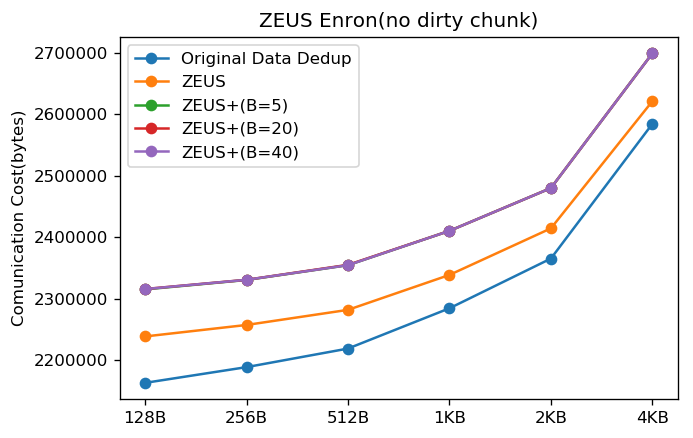

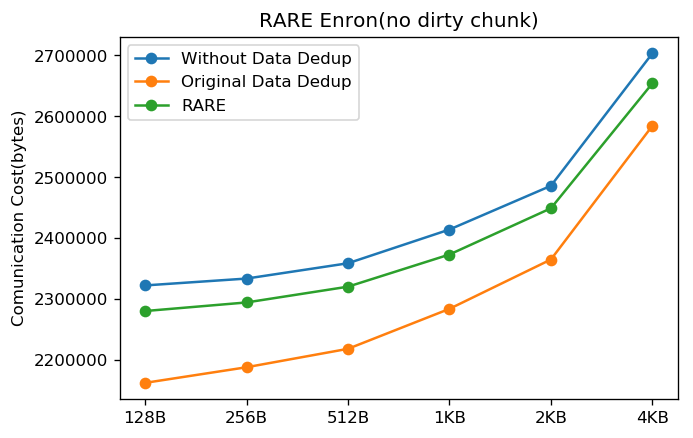

In [49]:
no_dirty = [origin_costs.copy(), zeus_costs.copy(), zeus5_costs.copy(), zeus20_costs.copy(), zeus40_costs.copy()]
no_dirty_rare = [no_dedup_costs.copy(), origin_dedup_costs.copy(), rare_costs.copy()]

print("Origin Data Dedup:", origin_costs)
print("ZEUS:             ", zeus_costs)
print("ZEUS+(B=5):       ", zeus5_costs)
print("ZEUS+(B=20):      ", zeus20_costs)
print("ZEUS+(B=40):      ", zeus40_costs)
print('-------------')
print("Without Data Dedup:", no_dedup_costs)
print("Rare:              ", rare_costs)
print("Origin Data Dedup: ", origin_dedup_costs)


%matplotlib inline
import matplotlib.pyplot as plt 
plt.figure(dpi = 120)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(x, origin_costs,  '-o', label = 'Original Data Dedup')
plt.plot(x, zeus_costs,  '-o', label = 'ZEUS')
plt.plot(x, zeus5_costs,  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, zeus20_costs,  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, zeus40_costs,  '-o', label = 'ZEUS+(B=40)')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('ZEUS Enron(no dirty chunk)')
plt.show()

plt.figure(dpi = 120)
plt.plot(x, no_dedup_costs, '-o', label = 'Without Data Dedup')
plt.plot(x, origin_dedup_costs, '-o', label = 'Original Data Dedup')
plt.plot(x, rare_costs, '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('RARE Enron(no dirty chunk)')
plt.show()

In [50]:
cloud_hash.clear()
dirty_chunk.clear()
check_hash.clear()

origin_costs.clear()
zeus_costs.clear()
zeus5_costs.clear()
zeus20_costs.clear()
zeus40_costs.clear()

no_dedup_costs.clear()
origin_dedup_costs.clear()
rare_costs.clear()

# 10% dirty chunk 128B
upload_file(128)
cut_check_file(128)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(128, False, True, 0))
zeus_costs.append(cal_commu_cost(128, True, True, 0))
zeus5_costs.append(cal_commu_cost(128, True, True, 5))
zeus20_costs.append(cal_commu_cost(128, True, True, 20))
zeus40_costs.append(cal_commu_cost(128, True, True, 40))

no_dedup_costs.append(rare_cost(128, False, False, False))
origin_dedup_costs.append(rare_cost(128, True, False, True))
rare_costs.append(rare_cost(128, True, True, True))

dirty original dedup with chunk size: 128 bytes, dedup times: 1248, check times: 18148, dedup percentage: 6.876791 %
dirty ZEUS with chunk size: 128 bytes, dedup times: 658, check times: 18148, dedup percentage: 3.625744 %
dirty ZEUS having threshold 5, with chunk size: 128 bytes, dedup times: 60, check times: 18148, dedup percentage: 0.330615 %
dirty ZEUS having threshold 20, with chunk size: 128 bytes, dedup times: 56, check times: 18148, dedup percentage: 0.308574 %
dirty ZEUS having threshold 40, with chunk size: 128 bytes, dedup times: 55, check times: 18148, dedup percentage: 0.303064 %
no dedup with chunk size: 128 bytes, dedup times: 0, check times: 18148, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 128 bytes, dedup times: 1248, check times: 18148, dedup percentage: 6.876791 %
dirty RARE with chunk size: 128 bytes, dedup times: 336, check times: 18148, dedup percentage: 1.851444 %


In [51]:
cloud_hash.clear()
dirty_chunk.clear()
check_hash.clear()

# 10% dirty chunk 256B
upload_file(256)
cut_check_file(256)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(256, False, True, 0))
zeus_costs.append(cal_commu_cost(256, True, True, 0))
zeus5_costs.append(cal_commu_cost(256, True, True, 5))
zeus20_costs.append(cal_commu_cost(256, True, True, 20))
zeus40_costs.append(cal_commu_cost(256, True, True, 40))
no_dedup_costs.append(rare_cost(256, False, False, False))
origin_dedup_costs.append(rare_cost(256, True, False, True))
rare_costs.append(rare_cost(256, True, True, True))

dirty original dedup with chunk size: 256 bytes, dedup times: 568, check times: 9118, dedup percentage: 6.229436 %
dirty ZEUS with chunk size: 256 bytes, dedup times: 300, check times: 9118, dedup percentage: 3.290195 %
dirty ZEUS having threshold 5, with chunk size: 256 bytes, dedup times: 14, check times: 9118, dedup percentage: 0.153542 %
dirty ZEUS having threshold 20, with chunk size: 256 bytes, dedup times: 14, check times: 9118, dedup percentage: 0.153542 %
dirty ZEUS having threshold 40, with chunk size: 256 bytes, dedup times: 13, check times: 9118, dedup percentage: 0.142575 %
no dedup with chunk size: 256 bytes, dedup times: 0, check times: 9118, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 256 bytes, dedup times: 568, check times: 9118, dedup percentage: 6.229436 %
dirty RARE with chunk size: 256 bytes, dedup times: 148, check times: 9118, dedup percentage: 1.623163 %


In [52]:
cloud_hash.clear()
dirty_chunk.clear()
check_hash.clear()

# 10% dirty chunk 512B
upload_file(512)
cut_check_file(512)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(512, False, True, 0))
zeus_costs.append(cal_commu_cost(512, True, True, 0))
zeus5_costs.append(cal_commu_cost(512, True, True, 5))
zeus20_costs.append(cal_commu_cost(512, True, True, 20))
zeus40_costs.append(cal_commu_cost(512, True, True, 40))
no_dedup_costs.append(rare_cost(512, False, False, False))
origin_dedup_costs.append(rare_cost(512, True, False, True))
rare_costs.append(rare_cost(512, True, True, True))

dirty original dedup with chunk size: 512 bytes, dedup times: 274, check times: 4608, dedup percentage: 5.946181 %
dirty ZEUS with chunk size: 512 bytes, dedup times: 151, check times: 4608, dedup percentage: 3.276910 %
dirty ZEUS having threshold 5, with chunk size: 512 bytes, dedup times: 8, check times: 4608, dedup percentage: 0.173611 %
dirty ZEUS having threshold 20, with chunk size: 512 bytes, dedup times: 8, check times: 4608, dedup percentage: 0.173611 %
dirty ZEUS having threshold 40, with chunk size: 512 bytes, dedup times: 8, check times: 4608, dedup percentage: 0.173611 %
no dedup with chunk size: 512 bytes, dedup times: 0, check times: 4608, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 512 bytes, dedup times: 274, check times: 4608, dedup percentage: 5.946181 %
dirty RARE with chunk size: 512 bytes, dedup times: 71, check times: 4608, dedup percentage: 1.540799 %


In [53]:
cloud_hash.clear()
dirty_chunk.clear()
check_hash.clear()

# 10% dirty chunk 1KB
upload_file(1024)
cut_check_file(1024)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(1024, False, True, 0))
zeus_costs.append(cal_commu_cost(1024, True, True, 0))
zeus5_costs.append(cal_commu_cost(1024, True, True, 5))
zeus20_costs.append(cal_commu_cost(1024, True, True, 20))
zeus40_costs.append(cal_commu_cost(1024, True, True, 40))
no_dedup_costs.append(rare_cost(1024, False, False, False))
origin_dedup_costs.append(rare_cost(1024, True, False, True))
rare_costs.append(rare_cost(1024, True, True, True))

dirty original dedup with chunk size: 1024 bytes, dedup times: 127, check times: 2358, dedup percentage: 5.385920 %
dirty ZEUS with chunk size: 1024 bytes, dedup times: 74, check times: 2358, dedup percentage: 3.138253 %
dirty ZEUS having threshold 5, with chunk size: 1024 bytes, dedup times: 4, check times: 2358, dedup percentage: 0.169635 %
dirty ZEUS having threshold 20, with chunk size: 1024 bytes, dedup times: 4, check times: 2358, dedup percentage: 0.169635 %
dirty ZEUS having threshold 40, with chunk size: 1024 bytes, dedup times: 4, check times: 2358, dedup percentage: 0.169635 %
no dedup with chunk size: 1024 bytes, dedup times: 0, check times: 2358, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 1024 bytes, dedup times: 127, check times: 2358, dedup percentage: 5.385920 %
dirty RARE with chunk size: 1024 bytes, dedup times: 37, check times: 2358, dedup percentage: 1.569126 %


In [54]:
cloud_hash.clear()
dirty_chunk.clear()
check_hash.clear()

# 10% dirty chunk 2KB
upload_file(2048)
cut_check_file(2048)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(2048, False, True, 0))
zeus_costs.append(cal_commu_cost(2048, True, True, 0))
zeus5_costs.append(cal_commu_cost(2048, True, True, 5))
zeus20_costs.append(cal_commu_cost(2048, True, True, 20))
zeus40_costs.append(cal_commu_cost(2048, True, True, 40))

no_dedup_costs.append(rare_cost(2048, False, False, False))
origin_dedup_costs.append(rare_cost(2048, True, False, True))
rare_costs.append(rare_cost(2048, True, True, True))

dirty original dedup with chunk size: 2048 bytes, dedup times: 59, check times: 1214, dedup percentage: 4.859967 %
dirty ZEUS with chunk size: 2048 bytes, dedup times: 35, check times: 1214, dedup percentage: 2.883031 %
dirty ZEUS having threshold 5, with chunk size: 2048 bytes, dedup times: 3, check times: 1214, dedup percentage: 0.247117 %
dirty ZEUS having threshold 20, with chunk size: 2048 bytes, dedup times: 3, check times: 1214, dedup percentage: 0.247117 %
dirty ZEUS having threshold 40, with chunk size: 2048 bytes, dedup times: 3, check times: 1214, dedup percentage: 0.247117 %
no dedup with chunk size: 2048 bytes, dedup times: 0, check times: 1214, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 2048 bytes, dedup times: 59, check times: 1214, dedup percentage: 4.859967 %
dirty RARE with chunk size: 2048 bytes, dedup times: 16, check times: 1214, dedup percentage: 1.317957 %


In [55]:
cloud_hash.clear()
dirty_chunk.clear()
check_hash.clear()

# 10% dirty chunk 4KB
upload_file(4096)
cut_check_file(4096)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(4096, False, True, 0))
zeus_costs.append(cal_commu_cost(4096, True, True, 0))
zeus5_costs.append(cal_commu_cost(4096, True, True, 5))
zeus20_costs.append(cal_commu_cost(4096, True, True, 20))
zeus40_costs.append(cal_commu_cost(4096, True, True, 40))

no_dedup_costs.append(rare_cost(4096, False, False, False))
origin_dedup_costs.append(rare_cost(4096, True, False, True))
rare_costs.append(rare_cost(4096, True, True, True))

dirty original dedup with chunk size: 4096 bytes, dedup times: 29, check times: 660, dedup percentage: 4.393939 %
dirty ZEUS with chunk size: 4096 bytes, dedup times: 20, check times: 660, dedup percentage: 3.030303 %
dirty ZEUS having threshold 5, with chunk size: 4096 bytes, dedup times: 1, check times: 660, dedup percentage: 0.151515 %
dirty ZEUS having threshold 20, with chunk size: 4096 bytes, dedup times: 1, check times: 660, dedup percentage: 0.151515 %
dirty ZEUS having threshold 40, with chunk size: 4096 bytes, dedup times: 1, check times: 660, dedup percentage: 0.151515 %
no dedup with chunk size: 4096 bytes, dedup times: 0, check times: 660, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 4096 bytes, dedup times: 29, check times: 660, dedup percentage: 4.393939 %
dirty RARE with chunk size: 4096 bytes, dedup times: 10, check times: 660, dedup percentage: 1.515152 %


Origin Data Dedup: [2163200, 2188800, 2219008, 2284544, 2365440, 2584576]
ZEUS:              [2238720, 2257408, 2281984, 2338816, 2414592, 2621440]
ZEUS+(B=5):        [2315264, 2330624, 2355200, 2410496, 2480128, 2699264]
ZEUS+(B=20):       [2315776, 2330624, 2355200, 2410496, 2480128, 2699264]
ZEUS+(B=40):       [2315904, 2330880, 2355200, 2410496, 2480128, 2699264]
-------------
Without Data Dedup: [2322944, 2334208, 2359296, 2414592, 2486272, 2703360]
Rare:               [2279936, 2296320, 2322944, 2376704, 2453504, 2662400]
Origin Data Dedup:  [2163200, 2188800, 2219008, 2284544, 2365440, 2584576]


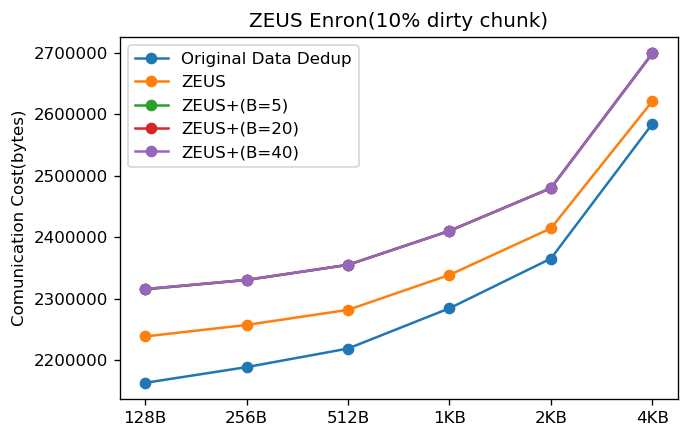

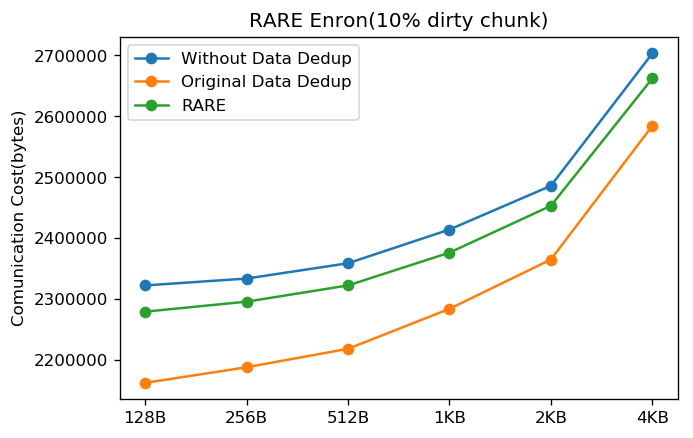

In [56]:
dirty10 = [origin_costs.copy(), zeus_costs.copy(), zeus5_costs.copy(), zeus20_costs.copy(), zeus40_costs.copy()]
dirty10_rare = [no_dedup_costs.copy(), origin_dedup_costs.copy(), rare_costs.copy()]

print("Origin Data Dedup:", origin_costs)
print("ZEUS:             ", zeus_costs)
print("ZEUS+(B=5):       ", zeus5_costs)
print("ZEUS+(B=20):      ", zeus20_costs)
print("ZEUS+(B=40):      ", zeus40_costs)
print('-------------')
print("Without Data Dedup:", no_dedup_costs)
print("Rare:              ", rare_costs)
print("Origin Data Dedup: ", origin_dedup_costs)

plt.figure(dpi = 120)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(x, origin_costs,  '-o', label = 'Original Data Dedup')
plt.plot(x, zeus_costs,  '-o', label = 'ZEUS')
plt.plot(x, zeus5_costs,  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, zeus20_costs,  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, zeus40_costs,  '-o', label = 'ZEUS+(B=40)')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('ZEUS Enron(10% dirty chunk)')
plt.show()

plt.figure(dpi = 120)
plt.plot(x, no_dedup_costs, '-o', label = 'Without Data Dedup')
plt.plot(x, origin_dedup_costs, '-o', label = 'Original Data Dedup')
plt.plot(x, rare_costs, '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('RARE Enron(10% dirty chunk)')
plt.show()

In [57]:
cloud_hash.clear()
dirty_chunk.clear()
check_hash.clear()

origin_costs.clear()
zeus_costs.clear()
zeus5_costs.clear()
zeus20_costs.clear()
zeus40_costs.clear()

no_dedup_costs.clear()
origin_dedup_costs.clear()
rare_costs.clear()

# 25% dirty chunk 128B
upload_file(128)
cut_check_file(128)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(128, False, True, 0))
zeus_costs.append(cal_commu_cost(128, True, True, 0))
zeus5_costs.append(cal_commu_cost(128, True, True, 5))
zeus20_costs.append(cal_commu_cost(128, True, True, 20))
zeus40_costs.append(cal_commu_cost(128, True, True, 40))
no_dedup_costs.append(rare_cost(128, False, False, False))
origin_dedup_costs.append(rare_cost(128, True, False, True))
rare_costs.append(rare_cost(128, True, True, True))

dirty original dedup with chunk size: 128 bytes, dedup times: 1248, check times: 18148, dedup percentage: 6.876791 %
dirty ZEUS with chunk size: 128 bytes, dedup times: 658, check times: 18148, dedup percentage: 3.625744 %
dirty ZEUS having threshold 5, with chunk size: 128 bytes, dedup times: 58, check times: 18148, dedup percentage: 0.319594 %
dirty ZEUS having threshold 20, with chunk size: 128 bytes, dedup times: 57, check times: 18148, dedup percentage: 0.314084 %
dirty ZEUS having threshold 40, with chunk size: 128 bytes, dedup times: 56, check times: 18148, dedup percentage: 0.308574 %
no dedup with chunk size: 128 bytes, dedup times: 0, check times: 18148, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 128 bytes, dedup times: 1248, check times: 18148, dedup percentage: 6.876791 %
dirty RARE with chunk size: 128 bytes, dedup times: 343, check times: 18148, dedup percentage: 1.890015 %


In [58]:
cloud_hash.clear()
dirty_chunk.clear()
check_hash.clear()

# 25% dirty chunk 256B
upload_file(256)
cut_check_file(256)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(256, False, True, 0))
zeus_costs.append(cal_commu_cost(256, True, True, 0))
zeus5_costs.append(cal_commu_cost(256, True, True, 5))
zeus20_costs.append(cal_commu_cost(256, True, True, 20))
zeus40_costs.append(cal_commu_cost(256, True, True, 40))
no_dedup_costs.append(rare_cost(256, False, False, False))
origin_dedup_costs.append(rare_cost(256, True, False, True))
rare_costs.append(rare_cost(256, True, True, True))

dirty original dedup with chunk size: 256 bytes, dedup times: 568, check times: 9118, dedup percentage: 6.229436 %
dirty ZEUS with chunk size: 256 bytes, dedup times: 300, check times: 9118, dedup percentage: 3.290195 %
dirty ZEUS having threshold 5, with chunk size: 256 bytes, dedup times: 14, check times: 9118, dedup percentage: 0.153542 %
dirty ZEUS having threshold 20, with chunk size: 256 bytes, dedup times: 13, check times: 9118, dedup percentage: 0.142575 %
dirty ZEUS having threshold 40, with chunk size: 256 bytes, dedup times: 14, check times: 9118, dedup percentage: 0.153542 %
no dedup with chunk size: 256 bytes, dedup times: 0, check times: 9118, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 256 bytes, dedup times: 568, check times: 9118, dedup percentage: 6.229436 %
dirty RARE with chunk size: 256 bytes, dedup times: 153, check times: 9118, dedup percentage: 1.678000 %


In [59]:
cloud_hash.clear()
dirty_chunk.clear()
check_hash.clear()

# 25% dirty chunk 512B
upload_file(512)
cut_check_file(512)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(512, False, True, 0))
zeus_costs.append(cal_commu_cost(512, True, True, 0))
zeus5_costs.append(cal_commu_cost(512, True, True, 5))
zeus20_costs.append(cal_commu_cost(512, True, True, 20))
zeus40_costs.append(cal_commu_cost(512, True, True, 40))
no_dedup_costs.append(rare_cost(512, False, False, False))
origin_dedup_costs.append(rare_cost(512, True, False, True))
rare_costs.append(rare_cost(512, True, True, True))

dirty original dedup with chunk size: 512 bytes, dedup times: 274, check times: 4608, dedup percentage: 5.946181 %
dirty ZEUS with chunk size: 512 bytes, dedup times: 151, check times: 4608, dedup percentage: 3.276910 %
dirty ZEUS having threshold 5, with chunk size: 512 bytes, dedup times: 9, check times: 4608, dedup percentage: 0.195312 %
dirty ZEUS having threshold 20, with chunk size: 512 bytes, dedup times: 8, check times: 4608, dedup percentage: 0.173611 %
dirty ZEUS having threshold 40, with chunk size: 512 bytes, dedup times: 9, check times: 4608, dedup percentage: 0.195312 %
no dedup with chunk size: 512 bytes, dedup times: 0, check times: 4608, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 512 bytes, dedup times: 274, check times: 4608, dedup percentage: 5.946181 %
dirty RARE with chunk size: 512 bytes, dedup times: 70, check times: 4608, dedup percentage: 1.519097 %


In [60]:
cloud_hash.clear()
dirty_chunk.clear()
check_hash.clear()

# 25% dirty chunk 1KB
upload_file(1024)
cut_check_file(1024)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(1024, False, True, 0))
zeus_costs.append(cal_commu_cost(1024, True, True, 0))
zeus5_costs.append(cal_commu_cost(1024, True, True, 5))
zeus20_costs.append(cal_commu_cost(1024, True, True, 20))
zeus40_costs.append(cal_commu_cost(1024, True, True, 40))
no_dedup_costs.append(rare_cost(1024, False, False, False))
origin_dedup_costs.append(rare_cost(1024, True, False, True))
rare_costs.append(rare_cost(1024, True, True, True))

dirty original dedup with chunk size: 1024 bytes, dedup times: 127, check times: 2358, dedup percentage: 5.385920 %
dirty ZEUS with chunk size: 1024 bytes, dedup times: 74, check times: 2358, dedup percentage: 3.138253 %
dirty ZEUS having threshold 5, with chunk size: 1024 bytes, dedup times: 4, check times: 2358, dedup percentage: 0.169635 %
dirty ZEUS having threshold 20, with chunk size: 1024 bytes, dedup times: 4, check times: 2358, dedup percentage: 0.169635 %
dirty ZEUS having threshold 40, with chunk size: 1024 bytes, dedup times: 4, check times: 2358, dedup percentage: 0.169635 %
no dedup with chunk size: 1024 bytes, dedup times: 0, check times: 2358, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 1024 bytes, dedup times: 127, check times: 2358, dedup percentage: 5.385920 %
dirty RARE with chunk size: 1024 bytes, dedup times: 32, check times: 2358, dedup percentage: 1.357082 %


In [61]:
cloud_hash.clear()
dirty_chunk.clear()
check_hash.clear()

# 25% dirty chunk 2KB
upload_file(2048)
cut_check_file(2048)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(2048, False, True, 0))
zeus_costs.append(cal_commu_cost(2048, True, True, 0))
zeus5_costs.append(cal_commu_cost(2048, True, True, 5))
zeus20_costs.append(cal_commu_cost(2048, True, True, 20))
zeus40_costs.append(cal_commu_cost(2048, True, True, 40))
no_dedup_costs.append(rare_cost(2048, False, False, False))
origin_dedup_costs.append(rare_cost(2048, True, False, True))
rare_costs.append(rare_cost(2048, True, True, True))

dirty original dedup with chunk size: 2048 bytes, dedup times: 59, check times: 1214, dedup percentage: 4.859967 %
dirty ZEUS with chunk size: 2048 bytes, dedup times: 35, check times: 1214, dedup percentage: 2.883031 %
dirty ZEUS having threshold 5, with chunk size: 2048 bytes, dedup times: 3, check times: 1214, dedup percentage: 0.247117 %
dirty ZEUS having threshold 20, with chunk size: 2048 bytes, dedup times: 3, check times: 1214, dedup percentage: 0.247117 %
dirty ZEUS having threshold 40, with chunk size: 2048 bytes, dedup times: 3, check times: 1214, dedup percentage: 0.247117 %
no dedup with chunk size: 2048 bytes, dedup times: 0, check times: 1214, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 2048 bytes, dedup times: 59, check times: 1214, dedup percentage: 4.859967 %
dirty RARE with chunk size: 2048 bytes, dedup times: 24, check times: 1214, dedup percentage: 1.976936 %


In [62]:
cloud_hash.clear()
dirty_chunk.clear()
check_hash.clear()

# 25% dirty chunk 4KB
upload_file(4096)
cut_check_file(4096)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(4096, False, True, 0))
zeus_costs.append(cal_commu_cost(4096, True, True, 0))
zeus5_costs.append(cal_commu_cost(4096, True, True, 5))
zeus20_costs.append(cal_commu_cost(4096, True, True, 20))
zeus40_costs.append(cal_commu_cost(4096, True, True, 40))
no_dedup_costs.append(rare_cost(4096, False, False, False))
origin_dedup_costs.append(rare_cost(4096, True, False, True))
rare_costs.append(rare_cost(4096, True, True, True))

dirty original dedup with chunk size: 4096 bytes, dedup times: 29, check times: 660, dedup percentage: 4.393939 %
dirty ZEUS with chunk size: 4096 bytes, dedup times: 20, check times: 660, dedup percentage: 3.030303 %
dirty ZEUS having threshold 5, with chunk size: 4096 bytes, dedup times: 1, check times: 660, dedup percentage: 0.151515 %
dirty ZEUS having threshold 20, with chunk size: 4096 bytes, dedup times: 1, check times: 660, dedup percentage: 0.151515 %
dirty ZEUS having threshold 40, with chunk size: 4096 bytes, dedup times: 1, check times: 660, dedup percentage: 0.151515 %
no dedup with chunk size: 4096 bytes, dedup times: 0, check times: 660, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 4096 bytes, dedup times: 29, check times: 660, dedup percentage: 4.393939 %
dirty RARE with chunk size: 4096 bytes, dedup times: 7, check times: 660, dedup percentage: 1.060606 %


Origin Data Dedup: [2163200, 2188800, 2219008, 2284544, 2365440, 2584576]
ZEUS:              [2238720, 2257408, 2281984, 2338816, 2414592, 2621440]
ZEUS+(B=5):        [2315520, 2330624, 2354688, 2410496, 2480128, 2699264]
ZEUS+(B=20):       [2315648, 2330880, 2355200, 2410496, 2480128, 2699264]
ZEUS+(B=40):       [2315776, 2330624, 2354688, 2410496, 2480128, 2699264]
-------------
Without Data Dedup: [2322944, 2334208, 2359296, 2414592, 2486272, 2703360]
Rare:               [2279040, 2295040, 2323456, 2381824, 2437120, 2674688]
Origin Data Dedup:  [2163200, 2188800, 2219008, 2284544, 2365440, 2584576]


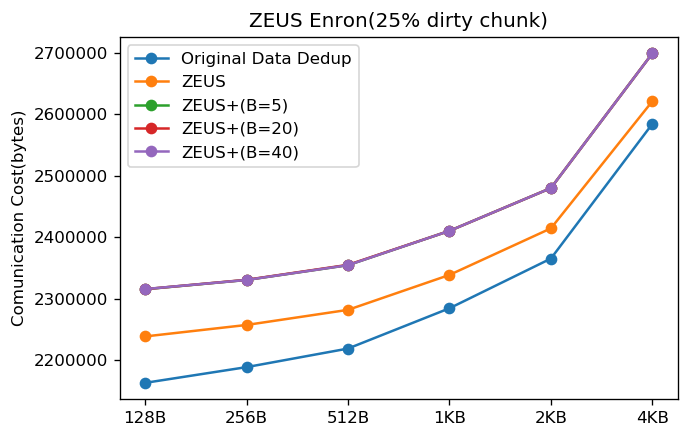

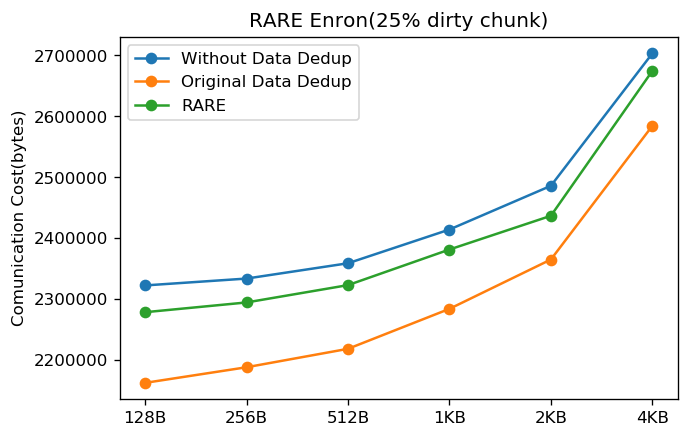

In [63]:
dirty25 = [origin_costs.copy(), zeus_costs.copy(), zeus5_costs.copy(), zeus20_costs.copy(), zeus40_costs.copy()]
dirty25_rare = [no_dedup_costs.copy(), origin_dedup_costs.copy(), rare_costs.copy()]

print("Origin Data Dedup:", origin_costs)
print("ZEUS:             ", zeus_costs)
print("ZEUS+(B=5):       ", zeus5_costs)
print("ZEUS+(B=20):      ", zeus20_costs)
print("ZEUS+(B=40):      ", zeus40_costs)
print('-------------')
print("Without Data Dedup:", no_dedup_costs)
print("Rare:              ", rare_costs)
print("Origin Data Dedup: ", origin_dedup_costs)

plt.figure(dpi = 120)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(x, origin_costs,  '-o', label = 'Original Data Dedup')
plt.plot(x, zeus_costs,  '-o', label = 'ZEUS')
plt.plot(x, zeus5_costs,  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, zeus20_costs,  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, zeus40_costs,  '-o', label = 'ZEUS+(B=40)')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('ZEUS Enron(25% dirty chunk)')
plt.show()

plt.figure(dpi = 120)
plt.plot(x, no_dedup_costs, '-o', label = 'Without Data Dedup')
plt.plot(x, origin_dedup_costs, '-o', label = 'Original Data Dedup')
plt.plot(x, rare_costs, '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('RARE Enron(25% dirty chunk)')
plt.show()

no dirty chunk					 10% dirty chunk				 25% dirty chunk
ZEUS
['128B', '256B', '512B', '1KB', '2KB', '4KB']
[2163200, 2188800, 2219008, 2284544, 2365440, 2584576] [2163200, 2188800, 2219008, 2284544, 2365440, 2584576] [2163200, 2188800, 2219008, 2284544, 2365440, 2584576]
[2238720, 2257408, 2281984, 2338816, 2414592, 2621440] [2238720, 2257408, 2281984, 2338816, 2414592, 2621440] [2238720, 2257408, 2281984, 2338816, 2414592, 2621440]
[2315264, 2330624, 2354688, 2410496, 2480128, 2699264] [2315264, 2330624, 2355200, 2410496, 2480128, 2699264] [2315520, 2330624, 2354688, 2410496, 2480128, 2699264]
[2315904, 2330880, 2355200, 2410496, 2480128, 2699264] [2315776, 2330624, 2355200, 2410496, 2480128, 2699264] [2315648, 2330880, 2355200, 2410496, 2480128, 2699264]
[2315776, 2330880, 2354688, 2410496, 2480128, 2699264] [2315904, 2330880, 2355200, 2410496, 2480128, 2699264] [2315776, 2330624, 2354688, 2410496, 2480128, 2699264]
--------------
RARE
[2322944, 2334208, 2359296, 2414592, 2486272, 27

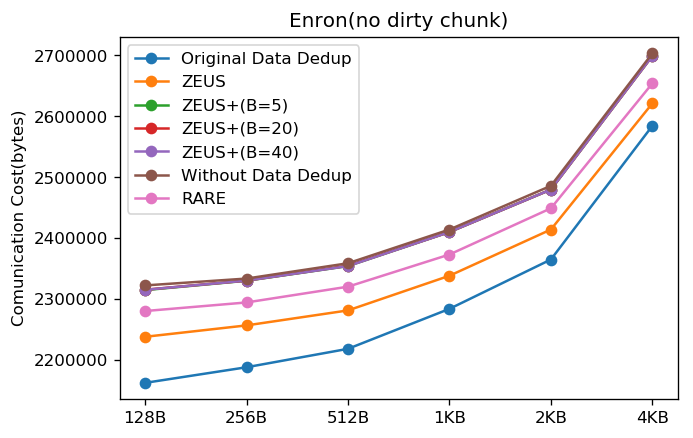

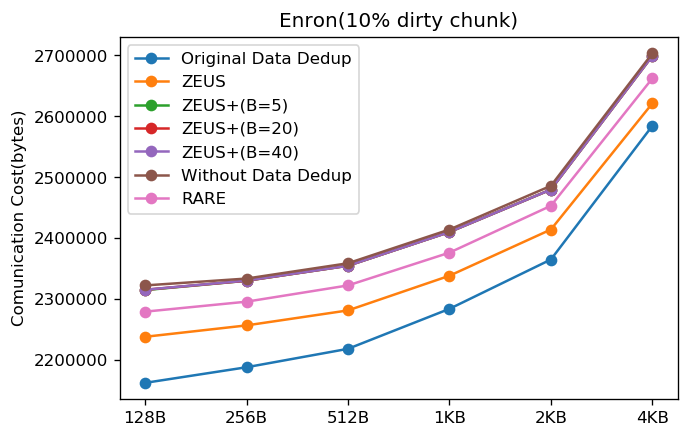

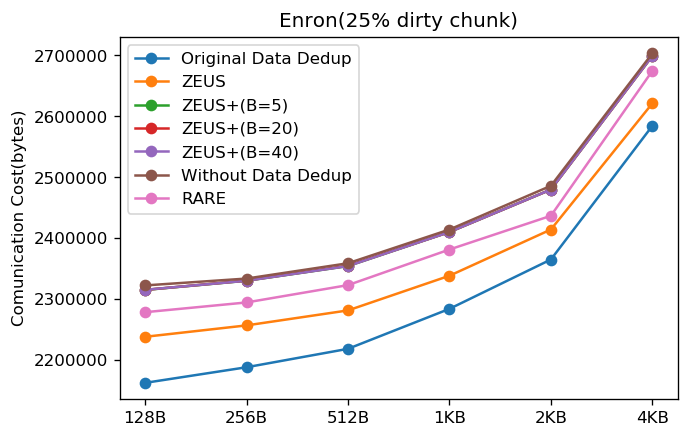

In [64]:
print('no dirty chunk\t\t\t\t\t', '10% dirty chunk\t\t\t\t', '25% dirty chunk')
print('ZEUS')
print(x)
for i in range(len(no_dirty)):
    print(no_dirty[i], dirty10[i], dirty25[i])
print('--------------')
print('RARE')
for i in range(len(no_dirty_rare)):
    print(no_dirty_rare[i], dirty10_rare[i], dirty25_rare[i])

plt.figure(dpi = 120)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(x, no_dirty[0],  '-o', label = 'Original Data Dedup')
plt.plot(x, no_dirty[1],  '-o', label = 'ZEUS')
plt.plot(x, no_dirty[2],  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, no_dirty[3],  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, no_dirty[4],  '-o', label = 'ZEUS+(B=40)')
plt.plot(x, no_dirty_rare[0], '-o', label = 'Without Data Dedup')
plt.plot(x, no_dirty_rare[2], '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('Enron(no dirty chunk)')
plt.show()
    
plt.figure(dpi = 120)
plt.plot(x, dirty10[0],  '-o', label = 'Original Data Dedup')
plt.plot(x, dirty10[1],  '-o', label = 'ZEUS')
plt.plot(x, dirty10[2],  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, dirty10[3],  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, dirty10[4],  '-o', label = 'ZEUS+(B=40)')
plt.plot(x, dirty10_rare[0], '-o', label = 'Without Data Dedup')
plt.plot(x, dirty10_rare[2], '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('Enron(10% dirty chunk)')
plt.show()

plt.figure(dpi = 120)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(x, origin_costs,  '-o', label = 'Original Data Dedup')
plt.plot(x, zeus_costs,  '-o', label = 'ZEUS')
plt.plot(x, zeus5_costs,  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, zeus20_costs,  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, zeus40_costs,  '-o', label = 'ZEUS+(B=40)')
plt.plot(x, dirty25_rare[0], '-o', label = 'Without Data Dedup')
plt.plot(x, dirty25_rare[2], '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('Enron(25% dirty chunk)')
plt.show()

# plt.subplot(131)
# plt.figure(dpi = 120)
# x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
# plt.plot(x, no_dirty[0],  '-o', label = 'Original Data Dedup')
# plt.plot(x, no_dirty[1],  '-o', label = 'ZEUS')
# plt.plot(x, no_dirty[2],  '-o', label = 'ZEUS+(B=5)')
# plt.plot(x, no_dirty[3],  '-o', label = 'ZEUS+(B=20)')
# plt.plot(x, no_dirty[4],  '-o', label = 'ZEUS+(B=40)')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('ZEUS Enron(no dirty chunk)')
# plt.show()

# plt.subplot(132)
# plt.figure(dpi = 120)
# plt.plot(x, dirty10[0],  '-o', label = 'Original Data Dedup')
# plt.plot(x, dirty10[1],  '-o', label = 'ZEUS')
# plt.plot(x, dirty10[2],  '-o', label = 'ZEUS+(B=5)')
# plt.plot(x, dirty10[3],  '-o', label = 'ZEUS+(B=20)')
# plt.plot(x, dirty10[4],  '-o', label = 'ZEUS+(B=40)')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('ZEUS Enron(10% dirty chunk)')
# plt.show()

# plt.subplot(133)
# plt.figure(dpi = 120)
# x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
# plt.plot(x, origin_costs,  '-o', label = 'Original Data Dedup')
# plt.plot(x, zeus_costs,  '-o', label = 'ZEUS')
# plt.plot(x, zeus5_costs,  '-o', label = 'ZEUS+(B=5)')
# plt.plot(x, zeus20_costs,  '-o', label = 'ZEUS+(B=20)')
# plt.plot(x, zeus40_costs,  '-o', label = 'ZEUS+(B=40)')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('ZEUS Enron(25% dirty chunk)')
# plt.show()

# plt.subplot(131)
# plt.figure(dpi = 120)
# plt.plot(x, no_dirty_rare[0], '-o', label = 'Without Data Dedup')
# plt.plot(x, no_dirty_rare[1], '-o', label = 'Original Data Dedup')
# plt.plot(x, no_dirty_rare[2], '-o', label = 'RARE')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('RARE Enron(no dirty chunk)')
# plt.show()

# plt.subplot(232)
# plt.figure(dpi = 120)
# plt.plot(x, dirty10_rare[0], '-o', label = 'Without Data Dedup')
# plt.plot(x, dirty10_rare[1], '-o', label = 'Original Data Dedup')
# plt.plot(x, dirty10_rare[2], '-o', label = 'RARE')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('RAER Enron(10% dirty chunk)')
# plt.show()

# plt.subplot(233)
# plt.figure(dpi = 120)
# plt.plot(x, dirty25_rare[0], '-o', label = 'Without Data Dedup')
# plt.plot(x, dirty25_rare[1], '-o', label = 'Original Data Dedup')
# plt.plot(x, dirty25_rare[2], '-o', label = 'RARE')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('RARE Enron(25% dirty chunk)')
# plt.show()